# EDS296: Final Mini-Project
### **Authors**

Carmen Hoyt choyt@ucsb.edu

Ryan Green ryangreen@ucsb.edu

Rachel Swick rachelfswick@ucsb.edu

### [GitHub Repository](https://github.com/ceh58/eds296-final)

## Introduction

1. Choose a spatial region you find interesting, for whatever reason.

*Write a few paragraphs about this place! Include a relevant graphic or two (can be an
infographic or map from the Internet) showing the geographical and climatological context
of your region. What’s going on there? What types of extreme events are relevant? How
might you expect that climate change impacts could be felt by human or natural systems?*

**Region**: Indonesia

**Bounding box**: [92, 146, -15, 10]

**Climate**: 

Indonesia has a tropical climate, experiencing two seasons: wet (November-April) and dry (May-October).  It is a key part of the Coral Triangle, a region with at least 500 species of important reef-building corals. Corals are highly sensitive to changes in water temperature, and will bleach (expel their zooxanthellae) after prolonged exposure to warmer temperatrues (or changes of greater than 1°C). This could lead to widespread bleaching and mass coral loss. Coral loss has many implications for the oceans and the people that depend on them, such as loss in food source, coastal protection, and tourism. 

Indonesia's first mass bleacing event was recorded in [1997-1998](https://indonesia.wcs.org/Initiatives/Marine/Coral-Bleaching.aspx). Since then, there have also been bleaching events in [2016-2017 and 2021](https://theseapeople.org/2024/12/18/coral-bleaching-raja-ampat/). 

<img src="coral_triangle.png" alt="Coral Triangle" width="75%">

While using sea surface temperature would be preferable for understanding what is happening to corals during bleaching events, we decided to take a more holistic approach at understanding what is happening in Indonesia by looking at air surface temperature and precipitation. Since Indonesia is already being severly impacted by climate change, changes to temperature and precipitation can have even greater impacts to the region and its residents. 

Us in California are familar with El Niño weather events resulting in warm, rainy winters. However, in Indonesia, El Niño has the opposite effect, causing longer, hotter dry seasons. In the south pacific, El Niño weather events increase the temperature of the ocean's surface, causing a change in air pressure which pushes moist winds out to sea instead of on land. With climate change, El Niño weather events are lasting longer, which has the potential to cause droughts in Indonesia. [El Nino, Climate Change and the Effect on Indonesia](https://www.ums.ac.id/en/news/global-pulse/el-nino-climate-change-and-the-effect-on-indonesia)

We are interested in looking at historical (1900-1930) and late century (1995-2025) average air surface temperatures. We chose the late 20th century time period to cover the span of the mass bleaching events to see if there was a significant change (increase) in air temperature as compared to the historical temperature. 

## Metrics Definition

**Metrics**:

1. Regional averages

This will allow us to quantify climate change impacts over time and compare trends (time series). 

2. Time averages

This will allow us to see where climate change impacts are focused within the region of interest (maps). 

**Variables**:

- "pr"

Since Indonesia has wet and dry seasons, precipitation can be an important indicator for climate change impacts.

- "tas"

Additionally, much of Indonesia's economy is reliant upon the ocean. Changes in air surface temperature could be a good indicator of changing nearshore ocean temperatures.


## Data I/O

**Climate models**:

- CESM2

The [CESM2 (Community Earth System Model version 2)](https://www.cesm.ucar.edu/models/cesm2) is developed by the National Center for Atmospheric Research (NCAR) for participation in CMIP6 (Coupled Model Intercomparison Project Phase 6). Ocean components are simulated using POP2 (Parallel Ocean Program version 2) at approximately 1° horizontal resolution. 

- ACCESS-CM2

The [ACCESS-CM2 (Australian Community Climate and Earth-System Simulator Coupled Model version 2)](https://research.csiro.au/access/about/cm2/) is a climate model developed by the Australian Bureau of Meteorology and CSIRO for participation in the CMIP6 (Coupled Model Intercomparison Project Phase 6). Ocean variables are modeled using MOM5 (Modular Ocean Model version 5) at 1 x 1 degree resolution.

**Scenario**:

- SSP370: 'Regional Rivalry' 

The SSP3-7.0 scenario (Shared Socioeconomic Pathway 3 with a radiative forcing of 7.0 W/m² by 2100) is one of the future climate projections used in CMIP6. It represents a high-emissions pathway, with CO² emissions projected to double by 2100. This can lead to significant challenges in both mitigation and adaptation.

### Import Packages

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake
import s3fs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.stats as stats

ERROR 1: PROJ: proj_create_from_database: Open of /opt/anaconda3/envs/eds296-stevenson/share/proj failed


### Access the CMIP6 Database

In [2]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

## Metrics Computation

### Regional Averages Function (Time Series)

In [3]:
# for Amon data
def model_climate_regional(model, variable):

    # Extract the part of the catalog that goes with these search terms
    model_var_hist = catalog.search(source_id = model, experiment_id='historical', table_id= 'Amon', variable_id=variable)
    model_var_ssp = catalog.search(source_id = model, experiment_id='ssp370', table_id= 'Amon', variable_id=variable)
    
    # Make a list of the unique ensemble members
    # historical
    mems_hist = model_var_hist.df.member_id.unique()
    # SSP
    mems_ssp = model_var_ssp.df.member_id.unique()

    # Convert these to sets, find the intersection between them, and convert back to a list
    common_mems = list(set(mems_hist) & set(mems_ssp))
    
    # Define an empty list for output data
    model_data = []

    # Retrieve number of members the historical and SSP ensembles have in common
    num = len(common_mems)

    # Loop over all members-in-common
    for mem in range(num):
        # Print statement to keep track of which member we're working on
        print(common_mems[mem])
    
        # Figure out where this member is in the historical ensemble
        # True/False array showing whether or not the member_id matches our member of interest
        hist_mask = model_var_hist.df['member_id'] == common_mems[mem]
        # extract (first) location where the mask is True
        hist_loc = model_var_hist.df['member_id'][hist_mask].index[0]
    
        # Do the same thing for the SSP ensemble
        ssp_mask = model_var_ssp.df['member_id'] == common_mems[mem]
        ssp_loc = model_var_ssp.df['member_id'][ssp_mask].index[0]
    
        # Extract data from each entry as xarray
        data_hist = xr.open_zarr(model_var_hist.df['zstore'][hist_loc], storage_options={'anon': True})
        data_ssp = xr.open_zarr(model_var_ssp.df['zstore'][ssp_loc], storage_options={'anon': True})
    
        data_hist['time'] = data_hist.time.astype('datetime64[ns]')
        data_ssp['time'] = data_ssp.time.astype('datetime64[ns]')
    
        data_hist = data_hist.sel(time = slice('1850-01-01', '2014-12-31'))
        data_ssp = data_ssp.sel(time = slice('2015-01-01', '2100-12-31'))
    
        # Concatenate the historical and SSP data across the time dimension
        data = xr.concat([data_hist, data_ssp], dim="time")
        
        # Narrow down to Indonesia
        data = data.sel(lon=slice(92, 146), lat=slice(-15, 10))
    
        # Add the concatenated data to a list
        model_data.append(data)

    # Concatenate the list into a single xarray object
    model_data = xr.concat(model_data, dim="member")

    # Store the actual member information as values of the new dimension
    model_data = model_data.assign_coords(member=("member", common_mems))
    
     # Compute spatial mean over lat & lon for each member & time
    ts_by_member = model_data[variable].mean(dim=["lat", "lon"])
    
    # Compute ensemble mean and standard deviation across members
    ens_mean = ts_by_member.mean(dim="member")
    ens_std  = ts_by_member.std(dim="member")
    
     # Plot the ensemble mean time series
    fig, ax = plt.subplots(figsize=(20, 10))
    
    ax.plot(ens_mean['time'].values,
        ens_mean.values,
        color='firebrick',
        linewidth=2,
        label='Ensemble mean')
    
    ax.set_xlabel("Time", fontsize=16)
    ax.set_ylabel(f"{variable} ({model_data[variable].units})", fontsize=16)
    ax.set_title(f"{model} – Ensemble‐mean average of '{variable}' in Indonesia", fontsize=18)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

### Time Averages Function (Mapping)

In [4]:
#for Amon data
def model_climate_time(model, variable):

    # Extract the part of the catalog that goes with these search terms
    model_var_hist = catalog.search(source_id = model, experiment_id='historical', table_id= 'Amon', variable_id=variable)
    model_var_ssp = catalog.search(source_id = model, experiment_id='ssp370', table_id= 'Amon', variable_id=variable)
    
    # Make a list of the unique ensemble members
    # historical
    mems_hist = model_var_hist.df.member_id.unique()
    # SSP
    mems_ssp = model_var_ssp.df.member_id.unique()

    # Convert these to sets, find the intersection between them, and convert back to a list
    common_mems = list(set(mems_hist) & set(mems_ssp))
    
    # Define an empty list for output data
    model_data = []

    # Retrieve number of members the historical and SSP ensembles have in common
    num = len(common_mems)

    # Loop over all members-in-common
    for mem in range(num):
        # Print statement to keep track of which member we're working on
        print(common_mems[mem])
    
        # Figure out where this member is in the historical ensemble
        # True/False array showing whether or not the member_id matches our member of interest
        hist_mask = model_var_hist.df['member_id'] == common_mems[mem]
        # extract (first) location where the mask is True
        hist_loc = model_var_hist.df['member_id'][hist_mask].index[0]
    
        # Do the same thing for the SSP ensemble
        ssp_mask = model_var_ssp.df['member_id'] == common_mems[mem]
        ssp_loc = model_var_ssp.df['member_id'][ssp_mask].index[0]
    
        # Extract data from each entry as xarray
        data_hist = xr.open_zarr(model_var_hist.df['zstore'][hist_loc], storage_options={'anon': True})
        data_ssp = xr.open_zarr(model_var_ssp.df['zstore'][ssp_loc], storage_options={'anon': True})
    
        data_hist['time'] = data_hist.time.astype('datetime64[ns]')
        data_ssp['time'] = data_ssp.time.astype('datetime64[ns]')
    
        data_hist = data_hist.sel(time = slice('1850-01-01', '2014-12-31'))
        data_ssp = data_ssp.sel(time = slice('2015-01-01', '2100-12-31'))
    
        # Concatenate the historical and SSP data across the time dimension
        data = xr.concat([data_hist, data_ssp], dim="time")
    
        # Add the concatenated data to a list
        model_data.append(data)

    # Concatenate the list into a single xarray object
    model_data = xr.concat(model_data, dim="member")

    # Store the actual member information as values of the new dimension
    model_data = model_data.assign_coords(member=("member", common_mems))
    
    # Get data for an earlier period: 20th century
    data_early = model_data.sel(time=slice("1850-01-01", "1900-12-31"))

    # Get data for a later period: 21st century
    data_late = model_data.sel(time=slice("2050-01-01", "2100-12-31"))
    
    # Take the time average
    data_early_mn = data_early.mean(dim="time")
    data_late_mn = data_late.mean(dim="time")

    # Extract the values into Numpy arrays
    pr_early = data_early_mn[variable].values
    pr_late = data_late_mn[variable].values
    
    # Define empty output arrays
    # T-test
    pr_pvals_t = np.empty((len(data_early_mn.lat), len(data_early_mn.lon)))
    # Rank-sum test
    pr_pvals_rs = np.empty((len(data_early_mn.lat), len(data_early_mn.lon)))

    # Loop over lat, lon in the Numpy array
    for latidx in range(len(data_early_mn.lat)):
        for lonidx in range(len(data_early_mn.lon)):
            # Run test on each grid point
            # T-test
            ttest = stats.ttest_ind(pr_early[:,latidx, lonidx], pr_late[:, latidx, lonidx])
            # Rank-sum
            stat_rs, pval_rs = stats.ranksums(pr_early[:,latidx, lonidx], pr_late[:, latidx, lonidx])
        
            # Save results in the output array
            pr_pvals_rs[latidx, lonidx] = pval_rs
            pr_pvals_t[latidx, lonidx] = ttest.pvalue
            
    # Calculate ensemble-mean epoch difference
    ensmn_prdiff = pr_late.mean(axis=0) - pr_early.mean(axis=0)

    # Define object containing PlateCarree projection
    map = ccrs.PlateCarree()

    # Create figure/axis objects, use the map object to specify associated projection
    fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})
    # Plot temperature data on the axes using the coolwarm colormap
    plot = ax.pcolormesh(data_early_mn.lon, data_early_mn.lat, ensmn_prdiff, 
                     transform=map, cmap="Reds") #vmin=-6, vmax=6

    # Add colorbar and label it
    cbar = plt.colorbar(plot, ax=ax)
    cbar.set_label(f'{variable} ({model_data[variable].units})', fontsize=20)
    cbar.ax.tick_params(labelsize=20)
    # Add coastline/border lines
    # Set the extent to Indonesia
    ax.set_extent([92, 146, -15, 10], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    # Add grid lines
    gl = ax.gridlines(draw_labels=True, linestyle="--") 
    gl.top_labels = False
    gl.right_labels = False

    # Set font size for x, y-axis labels
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}


    # Statistical significance for historical vs future precip change regressed on gradient change
    latitudes, longitudes = np.where(pr_pvals_rs < 0.05)
    lats = data_early_mn.coords['lat'][latitudes].values
    lons = data_early_mn.coords['lon'][longitudes].values
    ax.scatter(lons, lats, color='black', s=0.1, transform=ccrs.PlateCarree())

    # Add title, show plot
    ax.set_title(f"{model}: {variable} (Late - Early)", fontsize= 20)
    plt.show()

## Visualizations

5. Create visualizations of climate change impacts.

*Make some plots showing your metrics and how they change as a function of time!*

r10i1p1f1
r4i1p1f1
r11i1p1f1


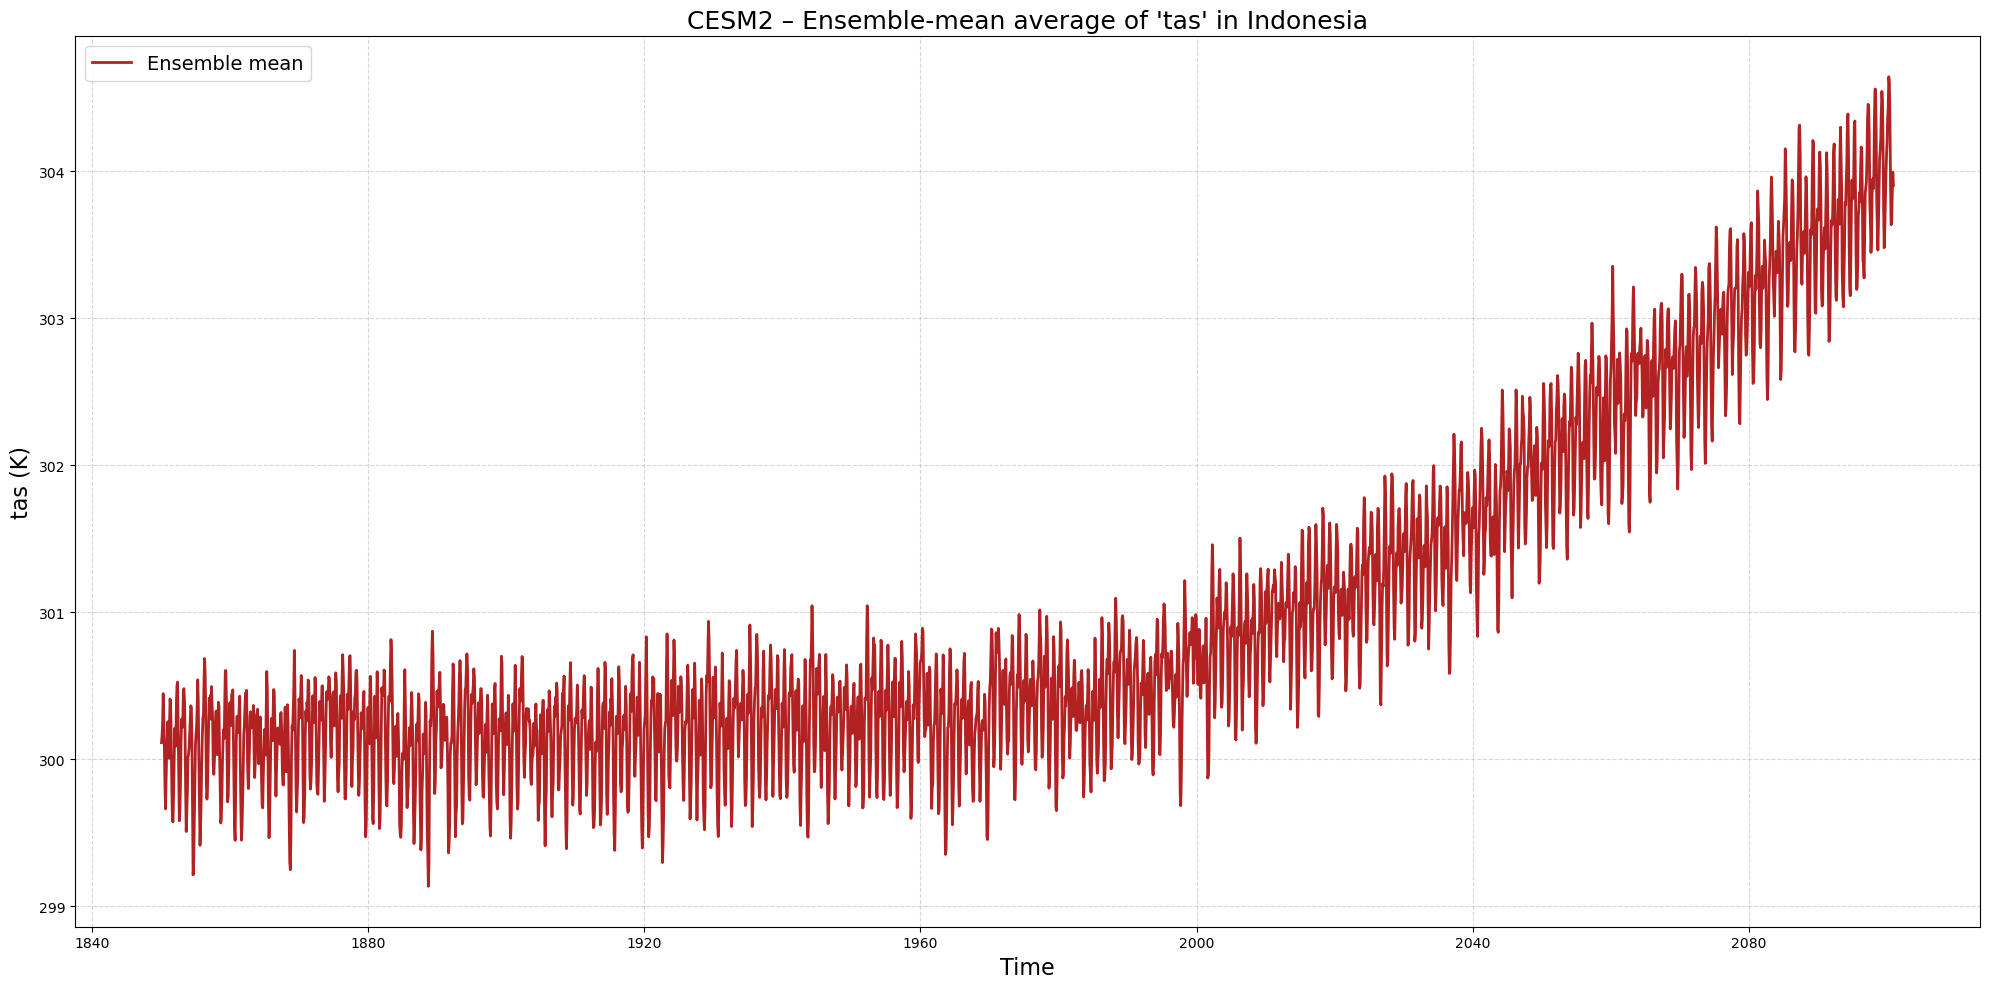

In [5]:
model_climate_regional('CESM2', 'tas')

r4i1p1f1
r11i1p1f1
r10i1p1f1


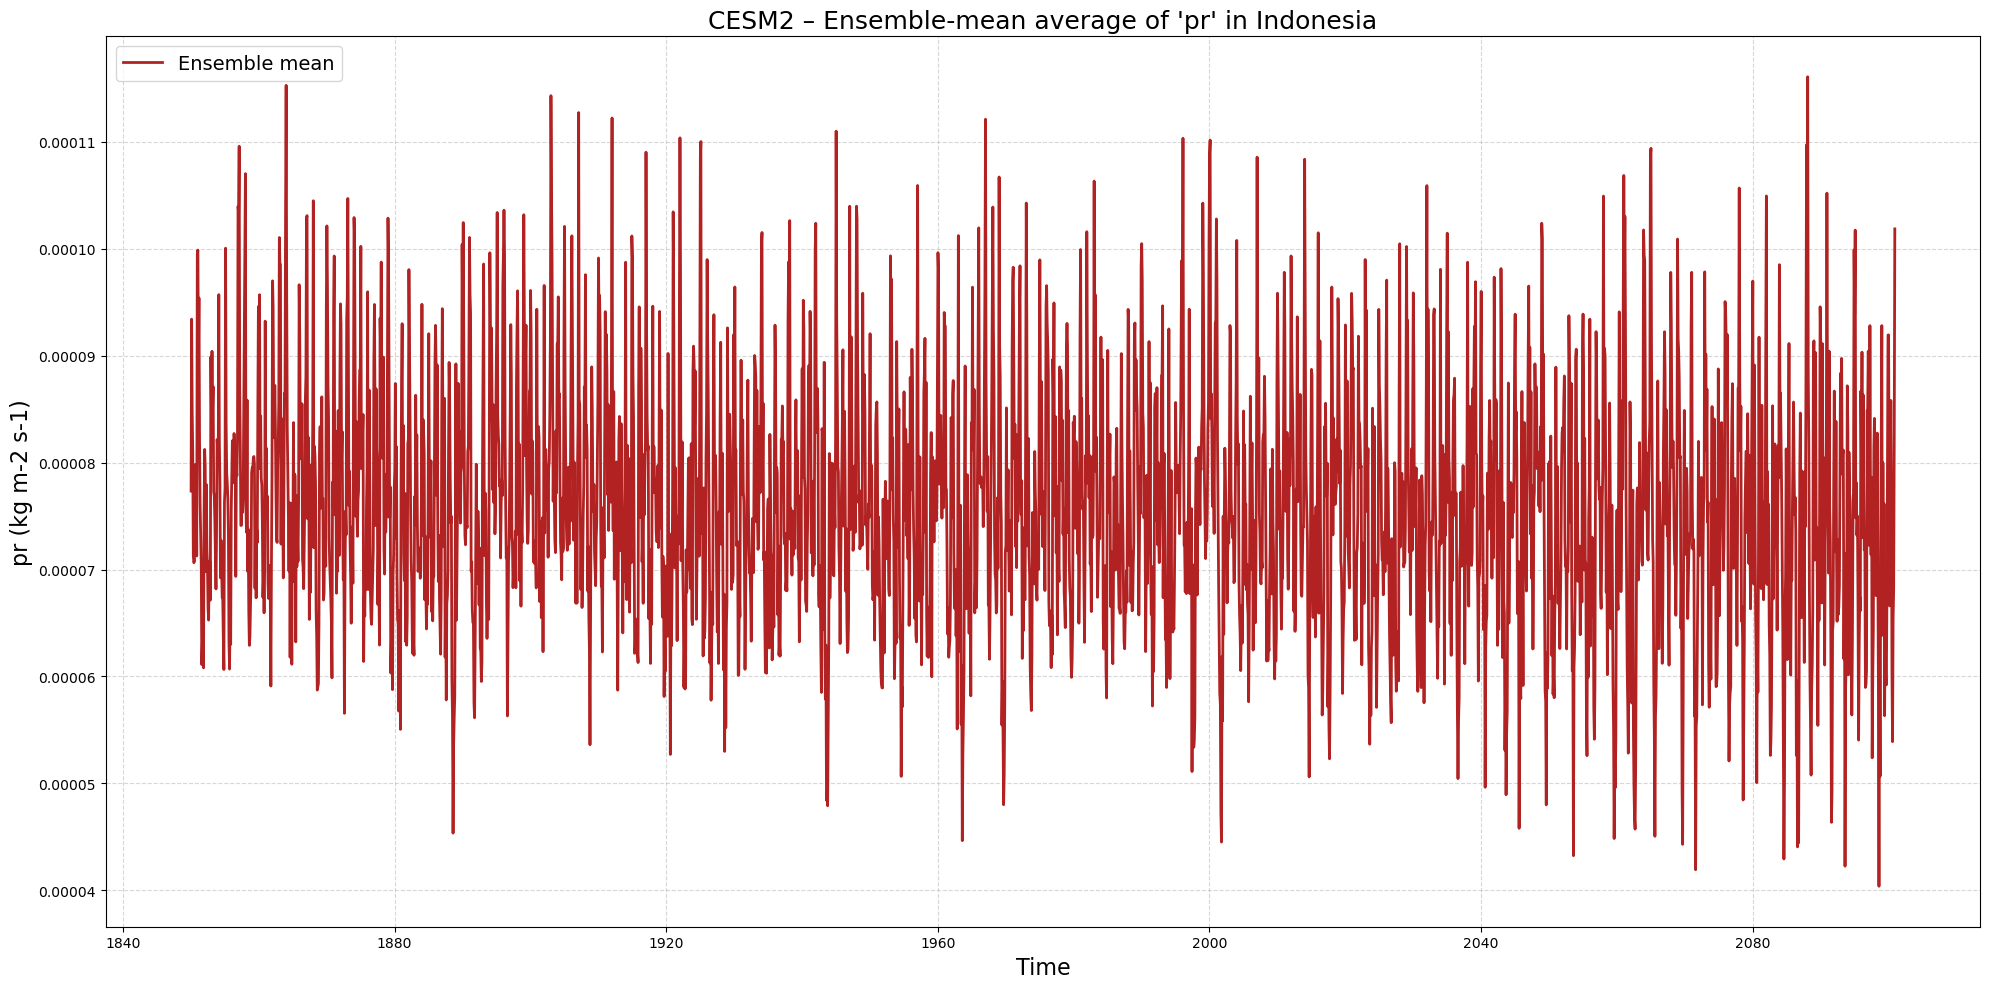

In [6]:
model_climate_regional('CESM2', 'pr')

r5i1p1f1
r3i1p1f1
r4i1p1f1
r1i1p1f1
r2i1p1f1


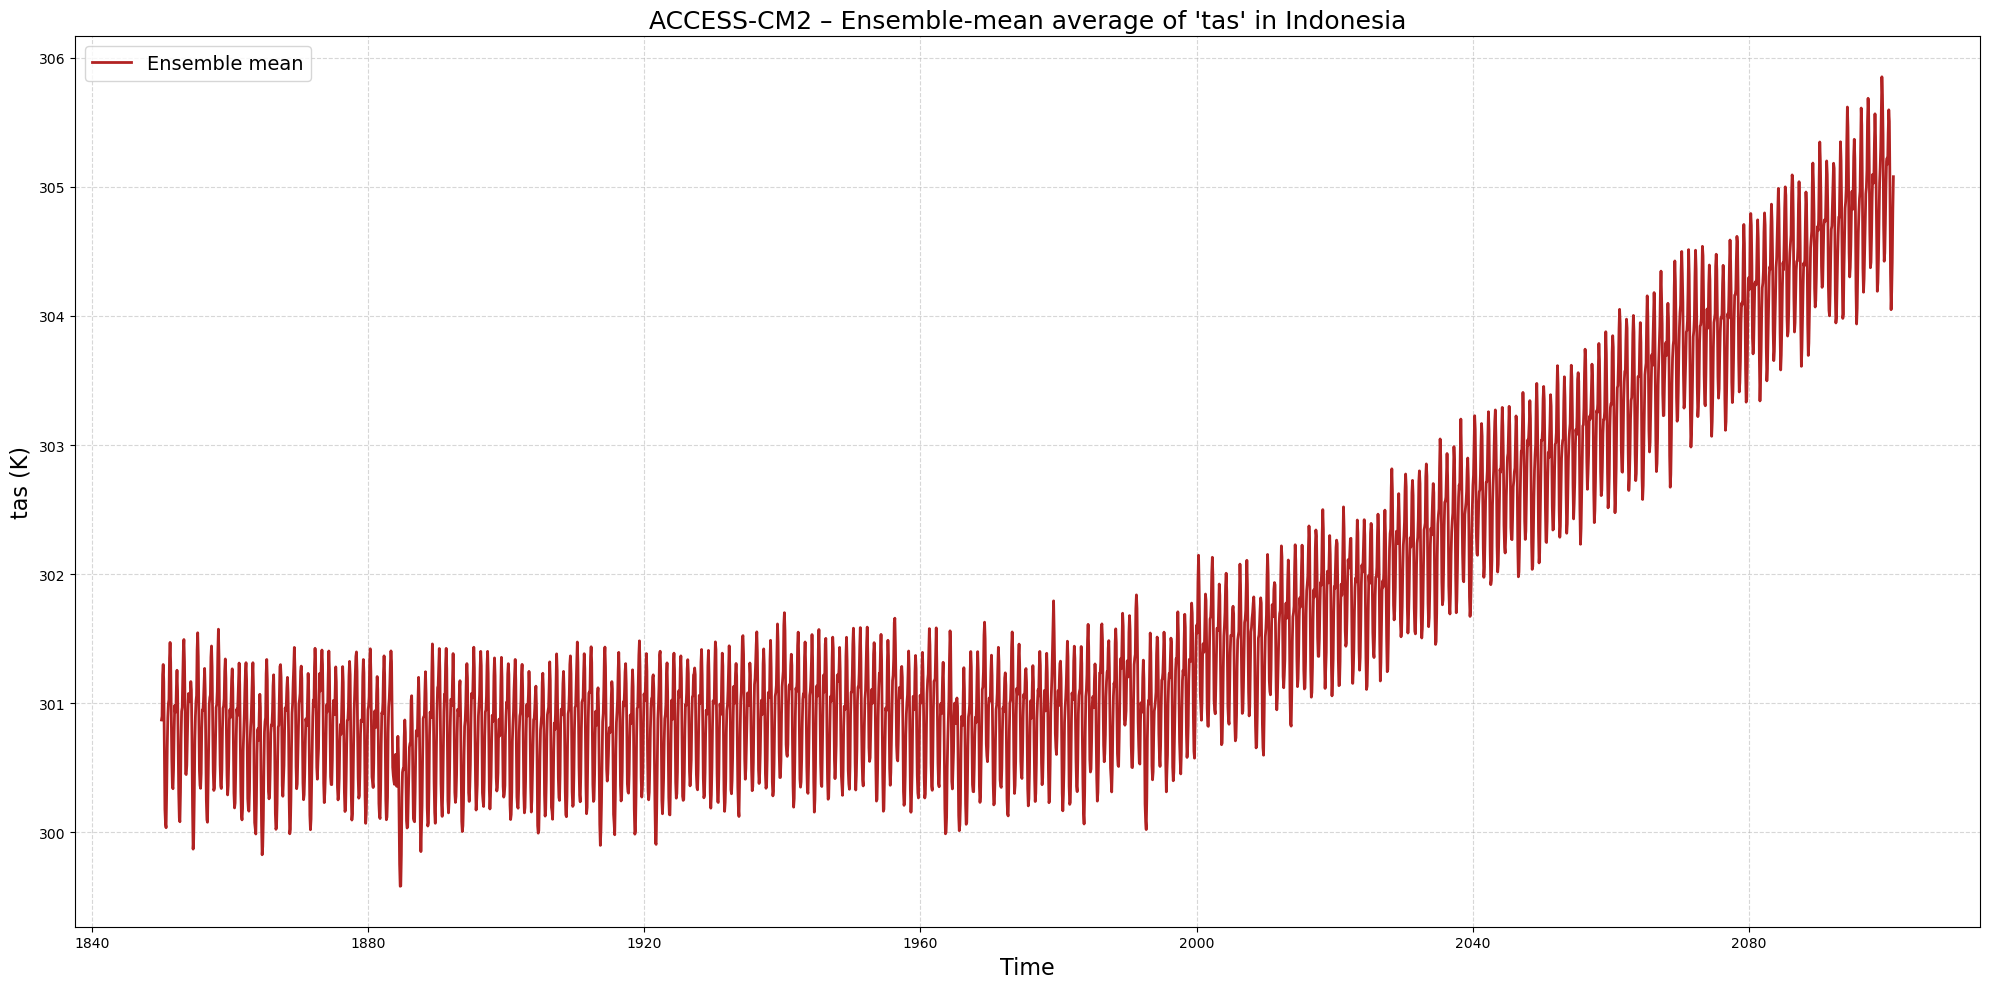

In [7]:
model_climate_regional('ACCESS-CM2', 'tas')

r5i1p1f1
r3i1p1f1
r4i1p1f1
r1i1p1f1
r2i1p1f1


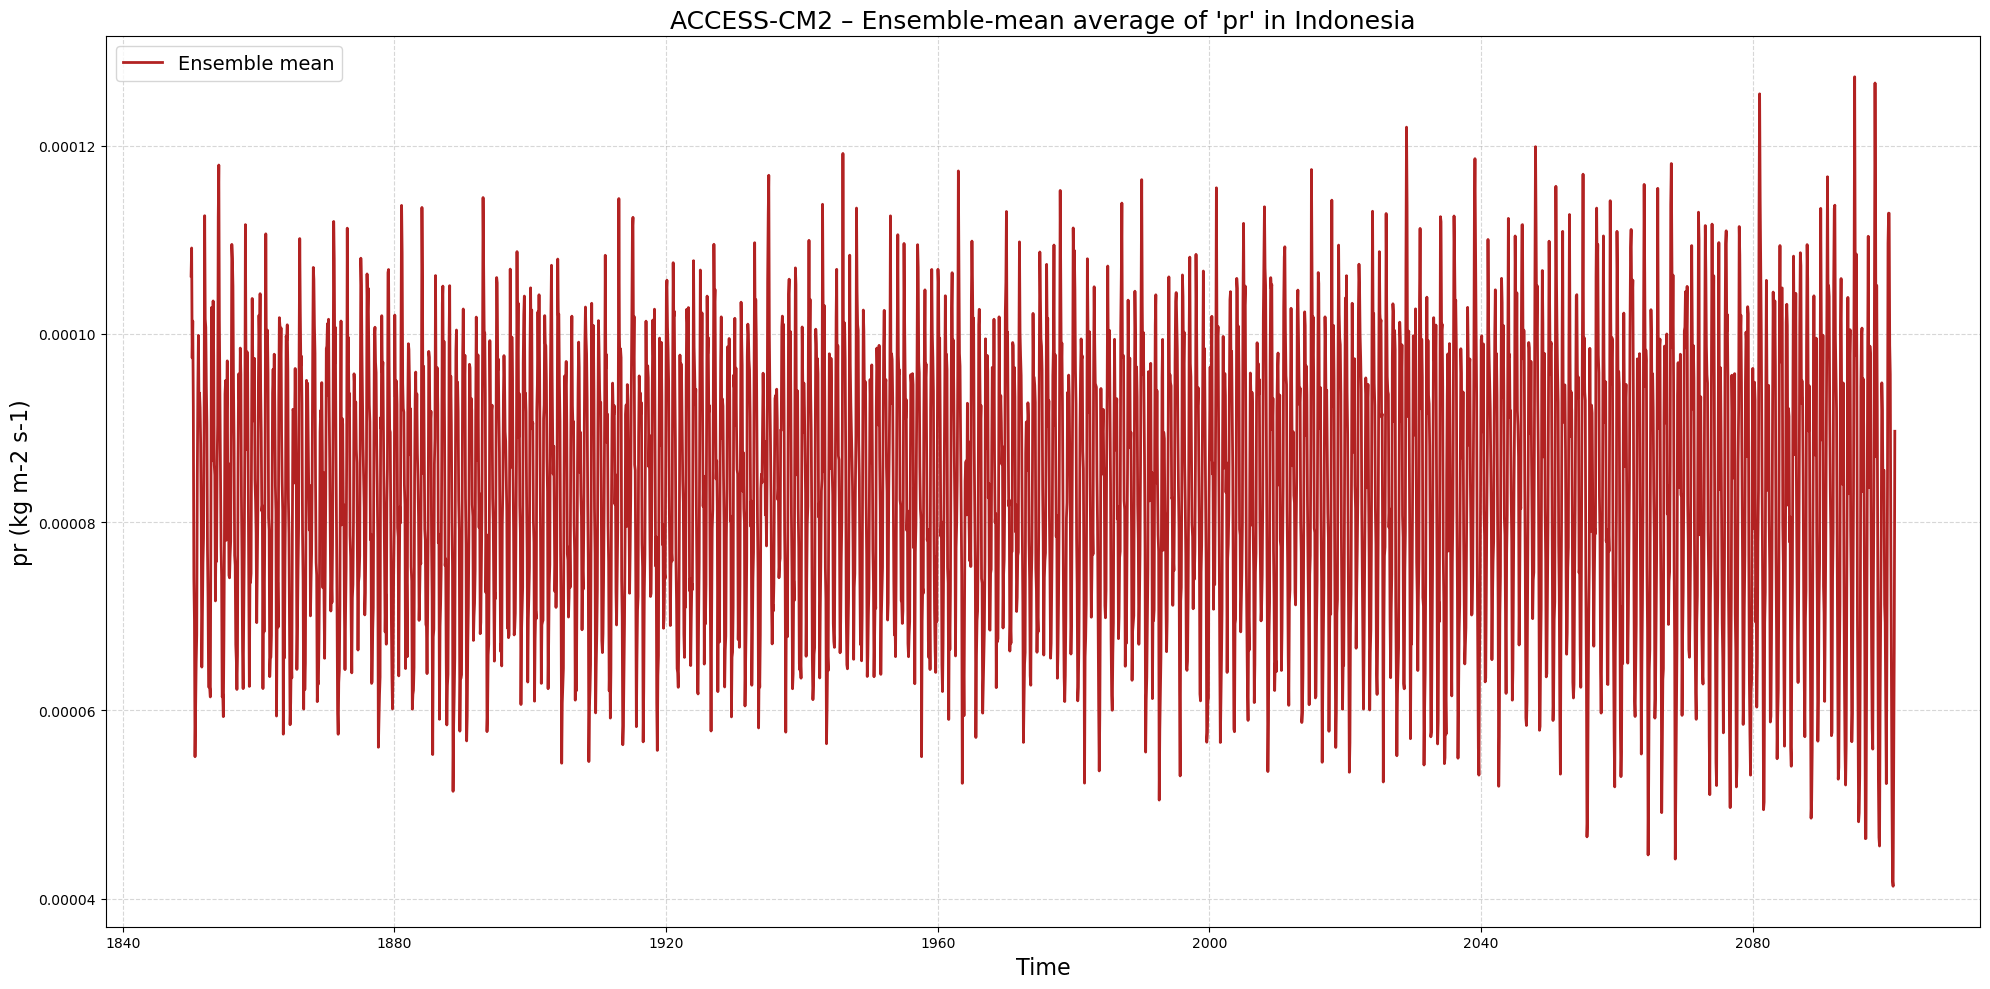

In [8]:
model_climate_regional('ACCESS-CM2', 'pr')

r10i1p1f1
r4i1p1f1
r11i1p1f1


/tmp/ipykernel_486040/1756413348.py:85: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest = stats.ttest_ind(pr_early[:,latidx, lonidx], pr_late[:, latidx, lonidx])


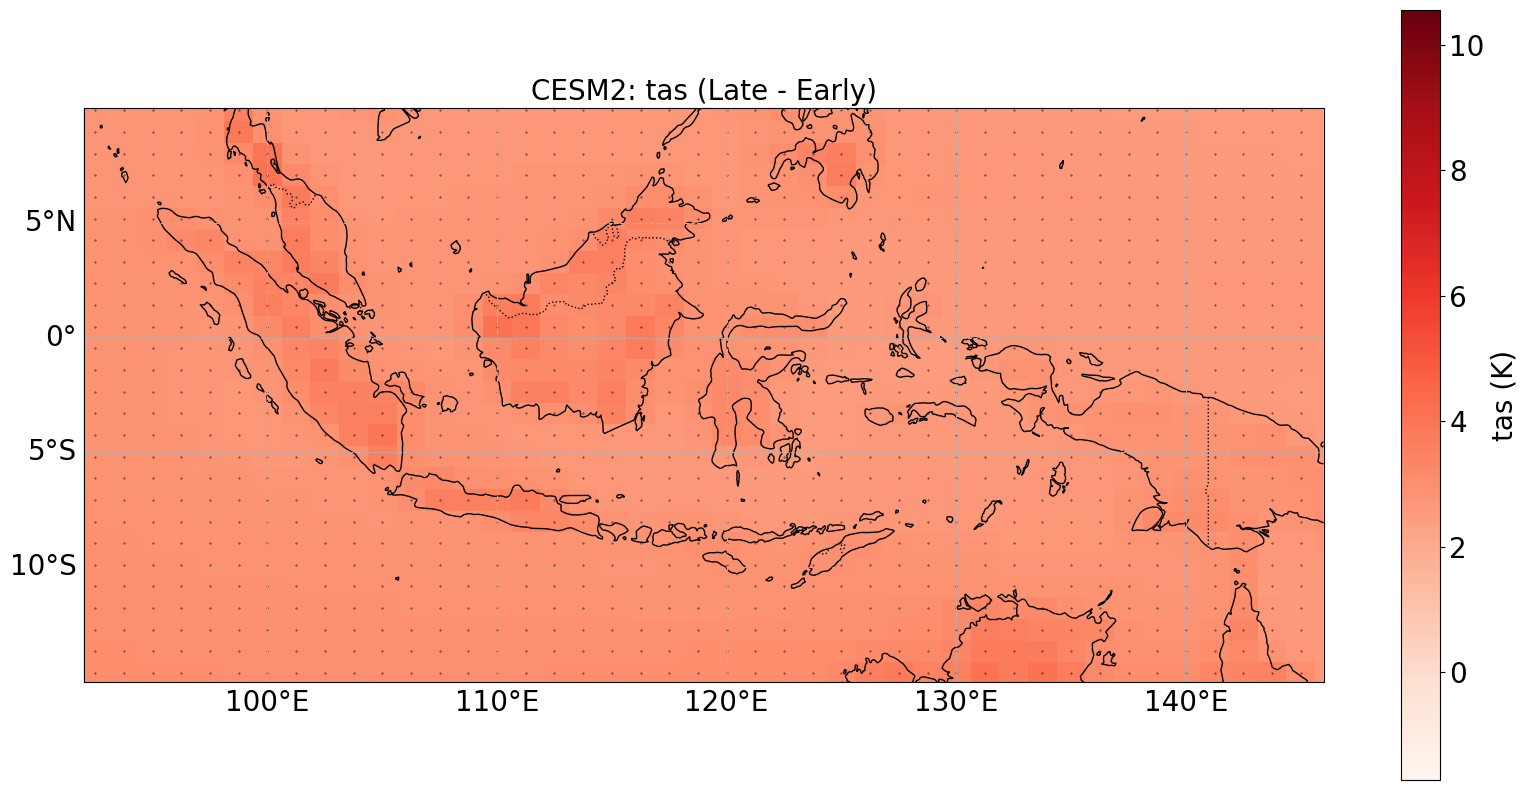

In [9]:
model_climate_time('CESM2', 'tas')

r4i1p1f1
r11i1p1f1
r10i1p1f1


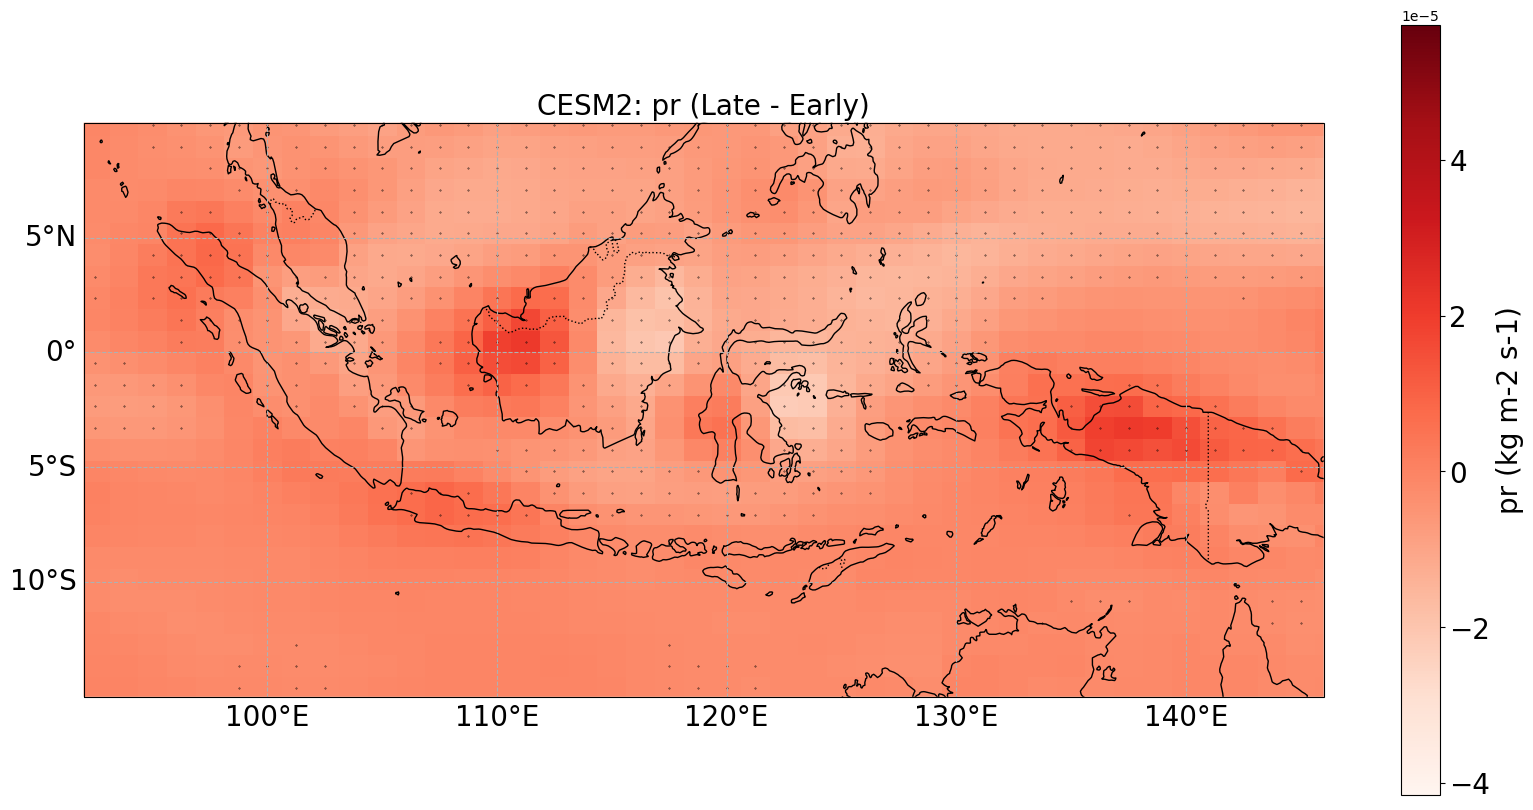

In [10]:
model_climate_time("CESM2", 'pr')

r5i1p1f1
r3i1p1f1
r4i1p1f1
r1i1p1f1
r2i1p1f1


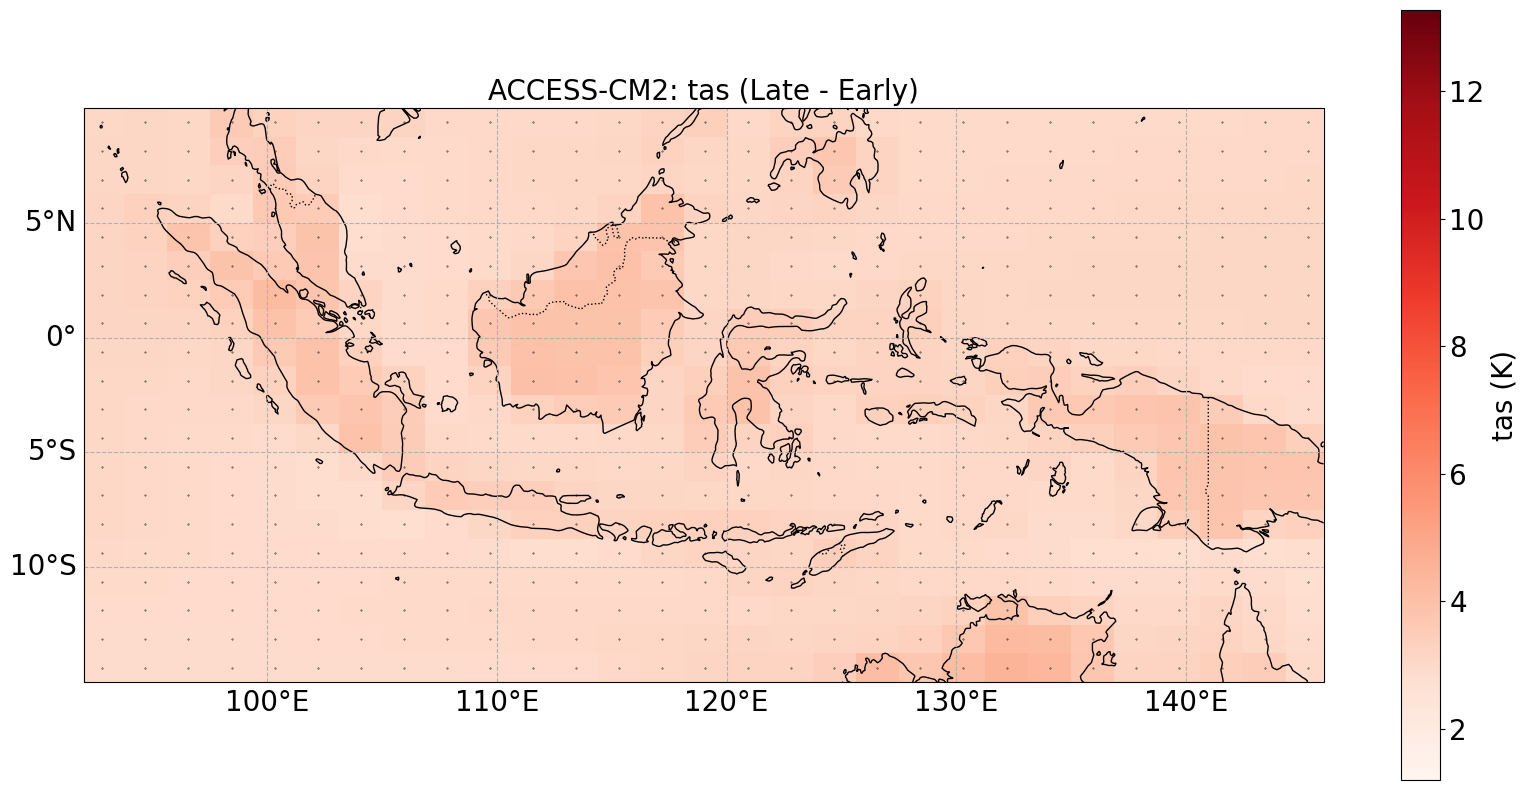

In [11]:
model_climate_time("ACCESS-CM2", 'tas')

r5i1p1f1
r3i1p1f1
r4i1p1f1
r1i1p1f1
r2i1p1f1


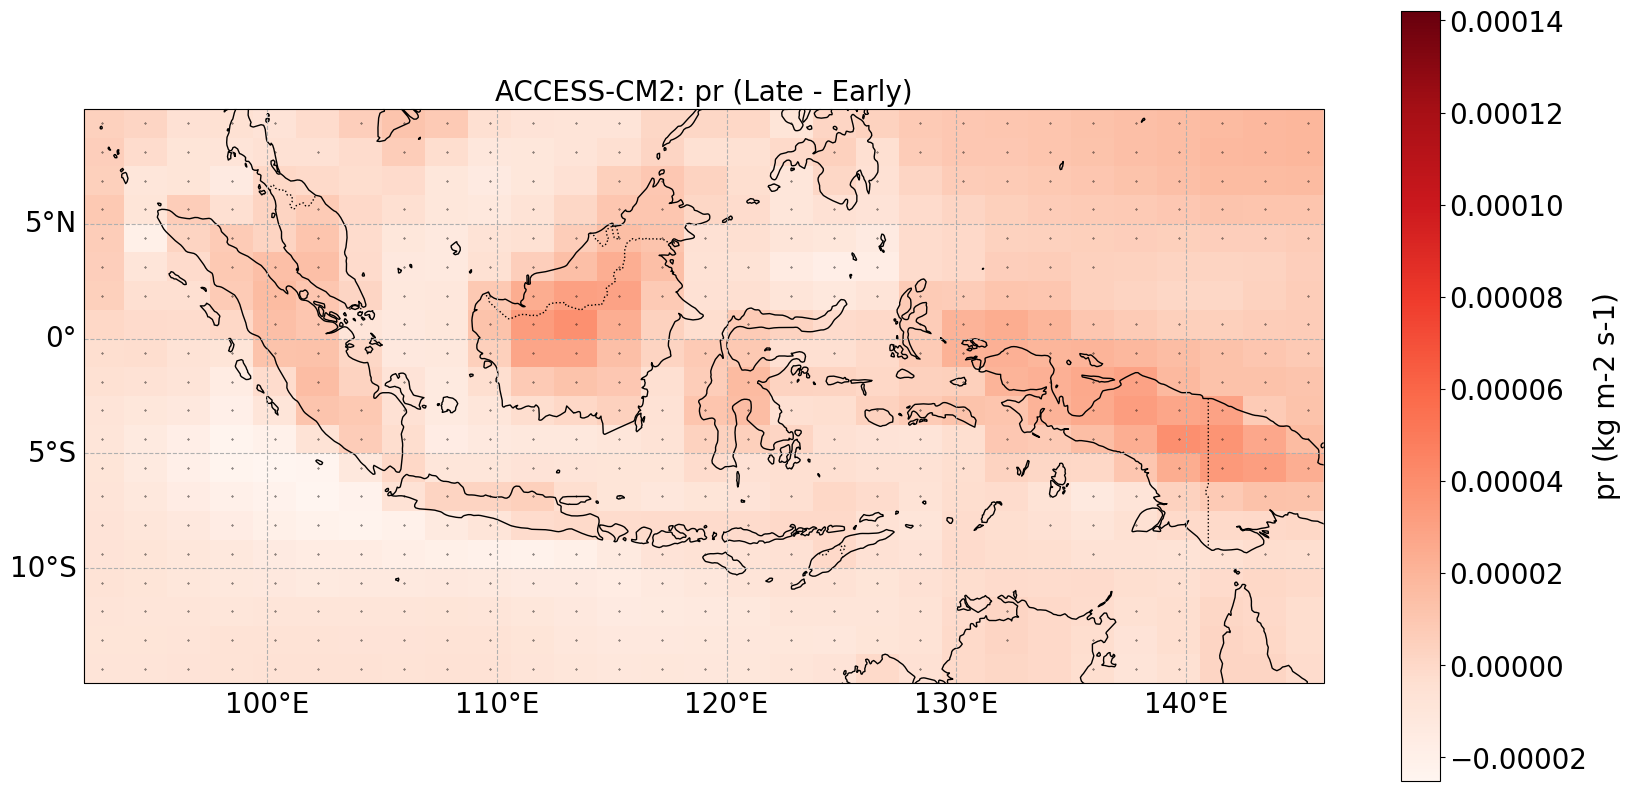

In [12]:
model_climate_time("ACCESS-CM2", 'pr')

## Conclusions

6. Interpret and contextualize your results.

*Finally, wrap it all up with a couple of paragraphs discussing your results and what you think
their implications might be for your region. For instance: what populations or ecosystems
might be impacted? How confident are you that the future changes are different from the
historical climate? Is there anything else you’re excited to talk about?*

To streamline our analysis, we created two functions: 

- model_climate_regional: models regional averages for the model and variables of interest

- model_climate_time: models time averages for the model and variables of interest


Our regional averages (time series) show:


Our time averages (maps) show:

The four maps above show the change between historical data and predicted future data (under future simulation SSP370) for both of our variables of interest: pr and tas. Both CESM2 and ACCESS appear to predict similar changes for tas concentrated on all the larger islands, despite some variation in the colorbar scale. This is a limitation of using our function, as it is more difficult to customize the maps. These changes show an increase of 2-4 degrees K (which corresponds to a 2-4 degree change in Celsius). This increase in air temperature could have adverse effects on coastal ocean temperatuers where coral reefs thrive, potentially leading to coral bleaching events. 

Both CESM2 and ACCESS appear to predict similar changes for pr as well, with changes concentrated around Bornea and New Guinea (both large, mountainous islands). These regions saw an increase of up to 0.00004 kg m-2 s-1 (roungly 3.5 mm/day). Interestingly enough, CESM2 shows a precipitation "shadow" on the east side of the islands, that indicates almost the reverse trend. This trend could be exacerbated by the El Niño events mentioned in the introduction. Increased rainfall has implications for coral reefs in terms of increased runoff, and the opposite could be true (extremely warm ocean temperatures and drought) for the shadows experiencing the reverse in rainfall trends.

Overall, we didn't use predicted data from very far into the future (only 2015-2025 data was simulated). Rather, our results may reflect more realistic changes, making these results all the most important to pay attention to. The stipples show a high degree of confidence in the change values displayed on the maps (significance above 90%) in all maps besides the southern portion of the CESM2 pr map.